In [106]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.cluster import KMeans,DBSCAN
from konlpy.tag import Okt
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
df = pd.read_csv('./customs_mail.csvv', low_memory=True)

In [3]:
len(df)

1214892

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1214892 entries, 0 to 1214891
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   관리년도         1214892 non-null  int64 
 1   검사일자         1214892 non-null  int64 
 2   검사년도         1214892 non-null  int64 
 3   우편물검사결과코드    1214892 non-null  int64 
 4   우편물검사결과코드.1  1214890 non-null  object
 5   우편물검사결과코드.2  1214890 non-null  object
 6   검사결과내용       533166 non-null   object
dtypes: int64(4), object(3)
memory usage: 64.9+ MB


In [5]:
df.head(3)

,관리년도,검사일자,검사년도,우편물검사결과코드,우편물검사결과코드.1,우편물검사결과코드.2,검사결과내용
0,2019,20191004,2019,12,재감(면세범위초과),12-재감(면세범위초과),재감(면세범위초과)
1,2019,20191101,2019,12,재감(면세범위초과),12-재감(면세범위초과),재감(면세범위초과)
2,2019,20191213,2019,12,재감(면세범위초과),12-재감(면세범위초과),"세관선별 : 분산반입 9건 , 170kg"


In [6]:
df['우편물검사결과코드.2'].value_counts()

18-우편통관과 인계         701683
00-이상없음(현장 면세)      380230
12-재감(면세범위초과)        79813
26-지재권침해물품           18081
99-기타                14563
01-검역인계(현장 면세)        6446
13-재감(가격심사대상)         4760
98-선도착 검사제외           4170
11-재감(자가사용범위초과)       1693
15-재감(검역 및 재감대상)       858
14-재감(세관장확인대상)         825
21-위해물품(총포,도검류)        691
16-재감(일반수입신고대상)        501
22-마약류                 425
27-조사의뢰(조사) 대상          84
23-위조증서류                33
24-위해식품류                27
28-외국환거래법 대상             5
25-금지품                   2
Name: 우편물검사결과코드.2, dtype: int64

In [7]:
df_etc = df[df['우편물검사결과코드.2'] =='99-기타']

In [8]:
len(df_etc)

14563

In [9]:
df_etc.head(3)

,관리년도,검사일자,검사년도,우편물검사결과코드,우편물검사결과코드.1,우편물검사결과코드.2,검사결과내용
705,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)비전자상거래
706,2019,20191105,2019,99,기타,99-기타,농산물(말린고추)-비전자상거래물품
762,2019,20191113,2019,99,기타,99-기타,농산물 반송


In [10]:
df_etc['검사결과내용'].value_counts()

농산물 반송       3226
농산물반송        2259
농산물          1927
담배반송         1414
담배           1359
             ... 
기타,농산물반송        1
이삿짐/반송          1
상용              1
농산물반입           1
분산 비전자 반송       1
Name: 검사결과내용, Length: 504, dtype: int64

In [11]:
#  결측값 유무 확인
df_etc['검사결과내용'].isnull().values.any()

# 결측값이 존재하는 행삭제
# df_etc = df_etc['검사결과내용'].dropna(how='any')

False

### 데이터 정비

In [12]:
# 정규 표현식을 통한 한글 외 문자 제거
df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")

C:\Users\P-이종권\AppData\Local\Temp\ipykernel_12388\2433001654.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
C:\Users\P-이종권\AppData\Local\Temp\ipykernel_12388\2433001654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")


In [13]:
df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타농산물","농산물").str.replace("이삿짐","이사화물").str.replace("담배반송"," 담배").str.replace("담배 반송"," 담배").str.replace("농산물반송"," 농산물").str.replace("농산물 반송"," 농산물").str.replace("이사화물 반송","이사화물").str.replace("기타담배반송","담배").str.replace("과일반송","과일").str.replace("기타 담배반송","담배").str.replace("기타 이사화물반송","이사화물")

C:\Users\P-이종권\AppData\Local\Temp\ipykernel_12388\2582553906.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타농산물","농산물").str.replace("이삿짐","이사화물").str.replace("담배반송"," 담배").str.replace("담배 반송"," 담배").str.replace("농산물반송"," 농산물").str.replace("농산물 반송"," 농산물").str.replace("이사화물 반송","이사화물").str.replace("기타담배반송","담배").str.replace("과일반송","과일").str.replace("기타 담배반송","담배").str.replace("기타 이사화물반송","이사화물")


In [14]:
df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타비전자반송","비전자상거래").str.replace("기타비전자상거래물품","비전자상거래").str.replace("농산물  담배","담배").str.replace("반송농산물","농산물").str.replace("비전자 반송","비전자상거래")\
.str.replace("비전자상거래 반송","비전자상거래").str.replace("비전자상거래물품","비전자상거래").str.replace("비전자상거래반송","비전자상거래").str.replace("이사물품 반송","이사물품")

C:\Users\P-이종권\AppData\Local\Temp\ipykernel_12388\323752328.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타비전자반송","비전자상거래").str.replace("기타비전자상거래물품","비전자상거래").str.replace("농산물  담배","담배").str.replace("반송농산물","농산물").str.replace("비전자 반송","비전자상거래")\


In [15]:
df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타 담배","담배").str.replace("기타담배","담배").str.replace("기타반송","기타").str.replace("농산물 담배","담배").str.replace("농산물담배","담배")\
.str.replace("반송담배","담배").str.replace("비전자반송","비전자상거래").str.replace("인근분산반입   농산물","농산물").str.replace("이사물품반송","이사물품")

C:\Users\P-이종권\AppData\Local\Temp\ipykernel_12388\2277108369.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_etc['검사결과내용'] = df_etc['검사결과내용'].str.replace("기타 담배","담배").str.replace("기타담배","담배").str.replace("기타반송","기타").str.replace("농산물 담배","담배").str.replace("농산물담배","담배")\


### 문장의 단어를 토큰화하고 word2vec을 학습 후 벡터하기

In [83]:
# 토큰화작업
import tqdm
okt = Okt()
tokenized_data = []
for sentence in tqdm.tqdm(df_etc['검사결과내용']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    tokenized_data.append(tokenized_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 14563/14563 [00:04<00:00, 3085.04it/s]


In [87]:
# 전채행
len(tokenized_data)

14563

In [88]:
# 행별로 토큰화된 결과 확인
tokenized_data[:3]

[['농산물', '말리다', '고추', '비', '전자상거래'],
 ['농산물', '말리다', '고추', '비', '전자상거래'],
 ['농산물']]

리뷰의 최대 길이 : 34
리뷰의 평균 길이 : 1.2438371214722241


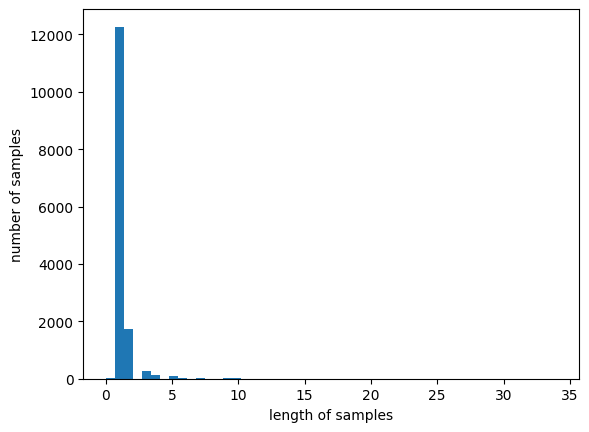

In [26]:
# 리뷰 길이 분포 확인
print('리뷰의 최대 길이 :',max(len(review) for review in tokenized_data))
print('리뷰의 평균 길이 :',sum(map(len, tokenized_data))/len(tokenized_data))
plt.hist([len(review) for review in tokenized_data], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [84]:
# 학습하기
# 임베딩 차원 : 100, 원도우사이즈 : 5, 등장빈도 min_count : 5
model = Word2Vec(sentences = tokenized_data, vector_size = 100, window = 5, min_count = 5, workers = 4, sg = 0)

In [28]:
# 완성된 임베딩 매트릭스의 크기 확인
model.wv.vectors.shape

(90, 100)

In [92]:
# 총 벡터화된 단어는 90개이고 그중 3개만 조회
model.wv.index_to_key[:2]

['농산물', '담배']

In [95]:
# 농산물, 담배단어의 임베딩 벡터
model.wv.vectors[:2]

array([[ 8.36350303e-03,  5.15341461e-02, -7.77557716e-02,
        -1.79834086e-02, -1.21809551e-02, -1.67713463e-01,
         8.94080289e-03,  1.28000975e-01, -1.47530064e-01,
        -1.33820042e-01, -2.32133158e-02, -1.75350737e-02,
        -5.62930144e-02, -4.59092204e-03,  1.49979725e-01,
         6.19329475e-02,  1.15175247e-01,  5.09217419e-02,
         2.68360190e-02, -1.71166807e-01,  8.92544761e-02,
        -2.10643522e-02,  1.59989417e-01, -6.15971684e-02,
         4.91060652e-02,  7.34078586e-02, -1.74010128e-01,
        -2.75494698e-02,  6.72514290e-02,  2.26153899e-02,
         1.71533763e-01,  1.14281452e-03,  1.16641432e-01,
        -8.39809999e-02,  3.24481837e-02,  1.93144009e-02,
        -6.26393706e-02,  6.32246882e-02, -4.05704789e-02,
        -1.62881702e-01, -3.07945292e-02, -8.06548297e-02,
         9.38350409e-02,  1.15516916e-01, -1.70071982e-03,
        -8.08320567e-02, -9.14556682e-02, -3.91248725e-02,
         8.98477957e-02,  1.21230580e-04,  9.58193094e-0

In [97]:
#특정 단어의 벡터값
model.wv["담배"]

array([-0.00064707,  0.05157148, -0.0717072 , -0.01924347,  0.00504613,
       -0.1557523 ,  0.00372166,  0.11672334, -0.13578756, -0.12698884,
       -0.02886332, -0.0236522 , -0.05342199, -0.00325088,  0.14780453,
        0.06674837,  0.11133079,  0.05427585,  0.02878855, -0.15138027,
        0.07873424, -0.02833275,  0.15133227, -0.06825842,  0.04669346,
        0.07439294, -0.16622332, -0.0267951 ,  0.06784239,  0.03126232,
        0.1768646 , -0.00252608,  0.09948903, -0.07677649,  0.03604515,
        0.0227699 , -0.05899211,  0.07058396, -0.02811006, -0.13823515,
       -0.01160493, -0.08694978,  0.0863553 ,  0.111265  , -0.00453801,
       -0.06692752, -0.07242668, -0.04707611,  0.08055733, -0.00683113,
        0.02440985, -0.08505493, -0.09861666,  0.03384322, -0.06400976,
        0.03537839,  0.04253413, -0.00680716,  0.02280091, -0.00084943,
        0.04047925,  0.10662249,  0.17509003,  0.12362065, -0.06919686,
        0.1564434 ,  0.06646573,  0.1152163 , -0.07848665,  0.00

In [77]:
# 모델에서 단어 벡터 추출
# word_vectors  = model.wv
# # 벡터 정규화
# from sklearn.preprocessing import normalize
# normalized_word_vectors = normalize(np.array([word_vectors[word] for word in word_vectors.vocab])).reshape(-1, 100)

### 문장(행)별 임베딩 벡터 합치기

In [98]:
rows_vectors = []
# 행별 단어 추출
for sentence in tqdm.tqdm(df_etc['검사결과내용']):
    tokenized_sentence = okt.morphs(sentence, stem=True)
    vectorized_sentence = []
    # 단어 하나씩 추출
    for token in tokenized_sentence:
        try:
            # 단어의 벡터값 뽑아서 저장
            vector = model.wv[token]
            vectorized_sentence.append(vector)
        except KeyError:
            pass
    rows_vectors.append(vectorized_sentence)

100%|██████████████████████████████████████████████████████████████████████████| 14563/14563 [00:04<00:00, 3116.80it/s]


In [101]:
# 첫번째 행의 벡터값
rows_vectors[:1]

[[array([ 8.36350303e-03,  5.15341461e-02, -7.77557716e-02, -1.79834086e-02,
         -1.21809551e-02, -1.67713463e-01,  8.94080289e-03,  1.28000975e-01,
         -1.47530064e-01, -1.33820042e-01, -2.32133158e-02, -1.75350737e-02,
         -5.62930144e-02, -4.59092204e-03,  1.49979725e-01,  6.19329475e-02,
          1.15175247e-01,  5.09217419e-02,  2.68360190e-02, -1.71166807e-01,
          8.92544761e-02, -2.10643522e-02,  1.59989417e-01, -6.15971684e-02,
          4.91060652e-02,  7.34078586e-02, -1.74010128e-01, -2.75494698e-02,
          6.72514290e-02,  2.26153899e-02,  1.71533763e-01,  1.14281452e-03,
          1.16641432e-01, -8.39809999e-02,  3.24481837e-02,  1.93144009e-02,
         -6.26393706e-02,  6.32246882e-02, -4.05704789e-02, -1.62881702e-01,
         -3.07945292e-02, -8.06548297e-02,  9.38350409e-02,  1.15516916e-01,
         -1.70071982e-03, -8.08320567e-02, -9.14556682e-02, -3.91248725e-02,
          8.98477957e-02,  1.21230580e-04,  9.58193094e-03, -7.65983015e-02,

In [104]:
df_etc['검사결과내용'][:1]

705    농산물말린고추비전자상거래
Name: 검사결과내용, dtype: object

In [107]:
# 모든행의 벡터의 길이를 맞춤
MAX_LEN = max(len(x) for x in rows_vectors)
padded_vectors = pad_sequences(rows_vectors, maxlen=MAX_LEN, padding='post', dtype='float32')

In [111]:
# k-means 클러스터링
kmeans = KMeans(n_clusters=10, random_state=42).fit(np.concatenate(padded_vectors))

In [109]:
# 클러스터링 결과 확인
labels = kmeans.labels_

In [114]:
# 클러스터링 결과를 데이터프레임에 추가
df_etc['cluster'] = df_etc.groupby('검사결과내용').ngroup().apply(lambda x: kmeans.labels_[x])

C:\Users\P-이종권\AppData\Local\Temp\ipykernel_12388\1136262429.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_etc['cluster'] = df_etc.groupby('검사결과내용').ngroup().apply(lambda x: kmeans.labels_[x])


In [115]:
df_etc

,관리년도,검사일자,검사년도,우편물검사결과코드,우편물검사결과코드.1,우편물검사결과코드.2,검사결과내용,cluster
705,2019,20191105,2019,99,기타,99-기타,농산물말린고추비전자상거래,0
706,2019,20191105,2019,99,기타,99-기타,농산물말린고추비전자상거래,0
762,2019,20191113,2019,99,기타,99-기타,농산물,8
935,2019,20191125,2019,99,기타,99-기타,이사화물,0
1015,2019,20191219,2019,99,기타,99-기타,과일,9
...,...,...,...,...,...,...,...,...
1211984,2023,20230316,2023,99,기타,99-기타,농산물,0
1211985,2023,20230316,2023,99,기타,99-기타,농산물,0
1213154,2023,20230605,2023,99,기타,99-기타,농산물,8
1214560,2023,20230705,2023,99,기타,99-기타,농산물,8


In [119]:
ㄱ닛 = df_etc.groupby(['cluster','검사결과내용'])['검사결과내용'].count()

cluster  검사결과내용   
0         농산물고춧가루     1
          농산물고춧가루등    1
          농산물대추       3
          농산물땅콩       7
          농산물말린고추     2
                     ..
9        담배다량 반송      3
         담배식품 반송      1
         이사물품분산반송     1
         전자담배 카트리지    1
         주류반송         1
Name: 검사결과내용, Length: 375, dtype: int64

In [124]:
rslt = df_etc.groupby(['cluster','검사결과내용'])['검사결과내용'].count().reset_index(name='ditc_count')

In [126]:
rslt.to_csv('./rslt.csv',index=False)